In [1]:
import os 
import sys

import numpy as np

from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor

import re

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")

from models.equivariant_mpnn import MPNNPORE

from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
hoa = np.load('C:/users/20175552/Code/zeolite-property-prediction/Data/MFI/hoa.npy')
henry = np.load('C:/users/20175552/Code/zeolite-property-prediction/Data/MFI/henry.npy')
ats_old = np.load('C:/users/20175552/Code/zeolite-property-prediction/Data/MFI/atoms.npy')

In [3]:
hoa.shape, henry.shape, ats_old.shape

((3296,), (3296,), (3296, 96))

In [4]:
data = get_zeolite('MFI', sym=True)

ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
_, _, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MFI')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)


In [5]:
X.shape

(96, 3)

In [6]:
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)


In [7]:
def get_ats(idx):
    with open(f'Data_isotherms/MFI/cifs/MFI_{idx}.cif') as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = [1 if i[0]=='Al' else 0 for i in at_pos]
    return atom

def get_iso(idx):
    with open(f'Data_isotherms/MFI/curves/plot_data_{idx}') as f:
        lines = f.read()
        #p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?)', lines)
        p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', lines)

    p = [float(i) for i in p]
    x = 10**np.arange(1,7,0.01)
    true_p = langmuirfreudlich(np.array(p)[None], x)

    return p

def langmuirfreudlich(p, x):
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])
    

In [8]:
# something went wrong with fitting MFI_33 and MFI_3296
n = 3296 - 2

atoms = np.zeros((n, 96))
iso_params = np.zeros((n, 6))


idxes = np.arange(1,n+1+2)
idxes = [i for i in idxes if i not in [33,3296]]

for zeo in tqdm(range(len(idxes))):

    idx = idxes[zeo]
    atoms[zeo] = get_ats(idx)
    iso_params[zeo] = get_iso(idx)

100%|██████████| 3294/3294 [00:51<00:00, 64.22it/s]


Text(0, 0.5, 'Loading (mol/kg)')

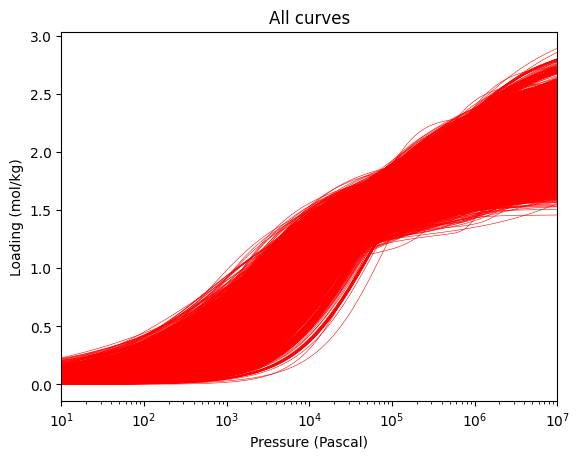

In [9]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(iso_params)):
    true_p = langmuirfreudlich(iso_params[[i]], x)
    plt.plot(x, true_p, alpha = 1, lw=.4, c='r')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('All curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [10]:
len(idxes)

3294

In [11]:
u_atoms = np.unique(ats_old, axis=0)
n = len(u_atoms)

iso_params1 = np.zeros((n,6))
hoa1 = np.zeros((n,))
henry1 = np.zeros((n,))

for i in range(n):
    mask1 = (u_atoms[i] == atoms).all(-1)
    if mask1.sum() < 1:
        print(i)
        continue
    # if mask1.sum() > 1:
    #     print(iso_params[mask1], i)
    #     print('----------------------')
    iso_params1[i] = iso_params[mask1][0]

    mask2 = (u_atoms[i] == ats_old).all(-1)

    if mask2.sum() < 1:
        print(i)#hoa[mask2], henry[mask2], i)

    hoa1[i] = np.mean(hoa[mask2])
    henry1[i] = np.log10(np.mean(henry[mask2]))

986
2805


In [12]:
henry1.min(), henry1.max()

(-4.59701167552354, 0.7573527490395943)

In [13]:
data_mask = ~(iso_params1 == 0).all(1)

In [14]:
iso_params1.shape, hoa1.shape, henry1.shape

((3077, 6), (3077,), (3077,))

In [15]:
data_y = np.concatenate([iso_params1[data_mask],hoa1[data_mask,None],henry1[data_mask,None]], 1)

In [16]:
data_y.shape

(3075, 8)

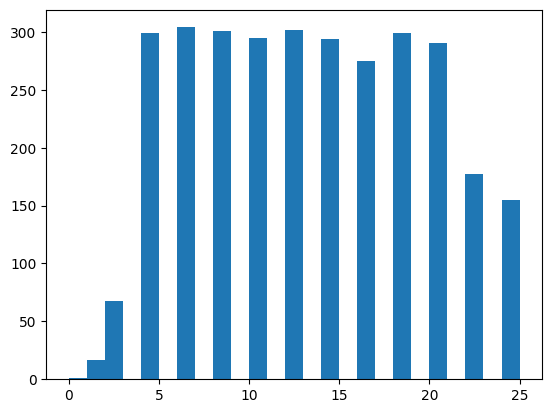

In [17]:
plt.hist(u_atoms.sum(1), bins=np.arange(0, 26));

In [18]:
def get_pred_points(steps):

    return 10**np.arange(1,7+1/steps,1/steps)
    

In [19]:
class calculate_distance(nn.Module):

    def __init__(self, pred_points):
        super().__init__()

        self.points = torch.tensor(pred_points)[:, None].to('cuda')#torch.tensor(10**np.arange(1,7+6/n_points,6/n_points))[:, None]
        self.n_points = pred_points.shape[0]
        
    def forward(self, p_hat, param_p):
        # add channels dimension
        #param_p_hat = param_p_hat[:,None]

        
        #p_hat = F.interpolate(param_p_hat, self.n_points+1, align_corners=True, mode='linear').squeeze()
        points = self.points.repeat(1, p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        #loss = ((p_hat - p)**2).mean(1)
        loss = ((p_hat - p).abs()).mean(1)
        return loss


class calculate_distance_points(nn.Module):

    def __init__(self, pred_points, mode='mae'):
        super().__init__()
        assert mode in ['mae','mse']
        self.mode = mode
        self.points = torch.tensor(pred_points)[:,None]
        
    def forward(self, param_p_hat, param_p):
        points = self.points.repeat(1, param_p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        if self.mode == 'mse':
            loss = ((param_p_hat - p)**2).mean(1)
        elif self.mode == 'mae':
            loss = ((param_p_hat - p).abs()).mean(1)
        return loss
        

        
    

In [20]:
_, testloader, trainloader = get_data_pore(u_atoms[data_mask], data_y, edges, pore, edges_sp, edges_ps, bs=32,random=True, p=1, test_size=0.08,drop_last=True)

In [21]:
trainloader.sampler, testloader.sampler

(<torch.utils.data.sampler.RandomSampler at 0x1664fc264a0>,
 <torch.utils.data.sampler.SequentialSampler at 0x1664fbdb190>)

Text(0, 0.5, 'Loading (mol/kg)')

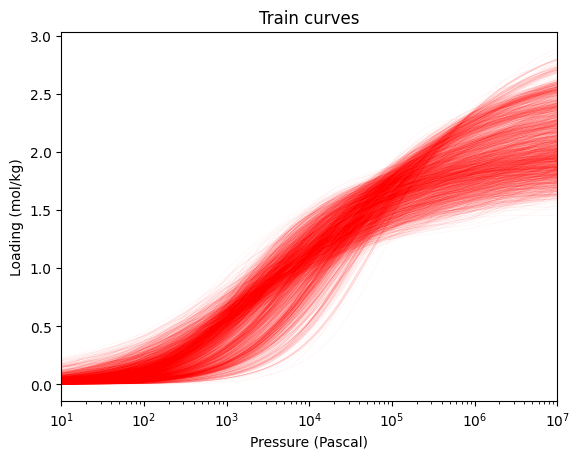

In [22]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy()[:,:-2], x)
    plt.plot(x, true_p, alpha = .1, lw=.2, c='r')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Train curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

Text(0, 0.5, 'Loading (mol/kg)')

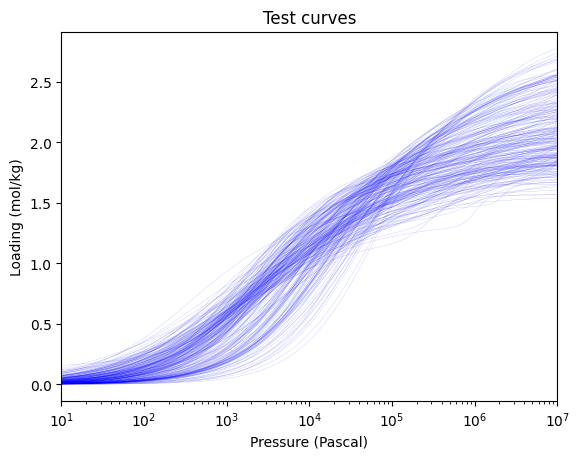

In [23]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(testloader.dataset)):
    true_p = langmuirfreudlich(testloader.dataset.y[[i]].numpy()[:,:-2], x)
    plt.plot(x, true_p, alpha = .3, lw=.2, c='b')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Test curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [24]:
pred_points = get_pred_points(20)

In [25]:
baseline_preds = np.zeros((pred_points.shape[0],))
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy()[:,:-2], pred_points)
    baseline_preds += true_p
baseline_preds /= len(trainloader.dataset)

In [26]:
errors = []
for i in range(len(testloader.dataset)):

    errors.append(calculate_distance_points(pred_points)(torch.tensor(baseline_preds)[None].cuda(), testloader.dataset.y[[i]].cuda()[:,:-2]).item())

In [27]:
print('baseline:', np.mean(errors))

baseline: 0.13770693507091739


Text(0, 0.5, 'Loading (mol/kg)')

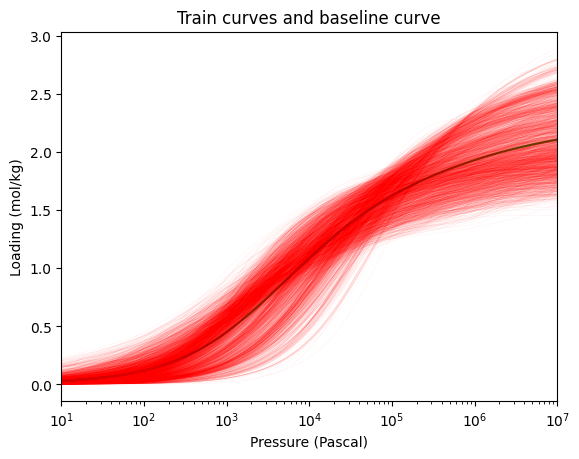

In [28]:
plt.plot(pred_points, baseline_preds, c='g')
x = 10**np.arange(1,7.01,0.01)
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy(), x)
    plt.plot(x, true_p, alpha = .1, lw=.2, c='r')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Train curves and baseline curve')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [29]:
len(pred_points), np.log10(pred_points)

(121,
 array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
        1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
        2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
        2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15,
        3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 ,
        3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
        4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
        4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
        5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 ,
        5.95, 6.  , 6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45,
        6.5 , 6.55, 6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  ]))

In [30]:
h_size = 12

In [31]:
class Gaussian(nn.Module):
    
    def __init__(self):
        
        super().__init__()
    
    def forward(self, x):
        
        return (-x.pow(2)).exp()

class GaussianSmearing(nn.Module):
    def __init__(
        self,
        start: float = 0.0,
        stop: float = 10.0,
        num_gaussians: int = 50,
    ):
        super().__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist: Tensor) -> Tensor:
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))

In [32]:
pred_points

array([1.00000000e+01, 1.12201845e+01, 1.25892541e+01, 1.41253754e+01,
       1.58489319e+01, 1.77827941e+01, 1.99526231e+01, 2.23872114e+01,
       2.51188643e+01, 2.81838293e+01, 3.16227766e+01, 3.54813389e+01,
       3.98107171e+01, 4.46683592e+01, 5.01187234e+01, 5.62341325e+01,
       6.30957344e+01, 7.07945784e+01, 7.94328235e+01, 8.91250938e+01,
       1.00000000e+02, 1.12201845e+02, 1.25892541e+02, 1.41253754e+02,
       1.58489319e+02, 1.77827941e+02, 1.99526231e+02, 2.23872114e+02,
       2.51188643e+02, 2.81838293e+02, 3.16227766e+02, 3.54813389e+02,
       3.98107171e+02, 4.46683592e+02, 5.01187234e+02, 5.62341325e+02,
       6.30957344e+02, 7.07945784e+02, 7.94328235e+02, 8.91250938e+02,
       1.00000000e+03, 1.12201845e+03, 1.25892541e+03, 1.41253754e+03,
       1.58489319e+03, 1.77827941e+03, 1.99526231e+03, 2.23872114e+03,
       2.51188643e+03, 2.81838293e+03, 3.16227766e+03, 3.54813389e+03,
       3.98107171e+03, 4.46683592e+03, 5.01187234e+03, 5.62341325e+03,
      

In [33]:
def get_eval_points(pred_points : torch.tensor):
    diff = pred_points[1] - pred_points[0]
    eval_points = torch.cat((pred_points, (pred_points[-1] + diff)[None]))
    eval_points = eval_points - diff/2
    return eval_points

def trapezoid(pred_dx : torch.tensor, eval_points : torch.tensor):

    dx = eval_points[1] - eval_points[0]

    y0 = pred_dx[:, :-1]
    y1 = pred_dx[:, 1:]

    trapz = 0.5 * dx * (y1 + y0)

    return trapz

def get_iso_points(pred_dx : torch.tensor, eval_points : torch.tensor):

    trapz = trapezoid(pred_dx, eval_points)

    return torch.cumsum(trapz, 1)

In [34]:
pred_points2 = get_pred_points(3)

p_points = torch.log10(torch.tensor(pred_points2))
e_points = get_eval_points(p_points)
pred_dx = torch.tensor([0,1,3,1,2.5,
                       1,4,2,2.1,1,
                       4,3,1,2,5,
                       10,1,1,1,2])

In [35]:
trapz = trapezoid(pred_dx[None], e_points)

In [36]:
pred_x = torch.cumsum(trapz, 1)

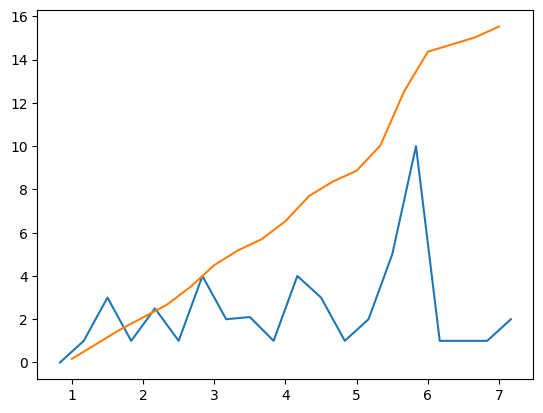

In [37]:
plt.plot(e_points, pred_dx)
plt.plot(p_points, pred_x[0])

In [38]:
class PoreLoading(nn.Module):

    def __init__(self, pred_points, out_size=32, f_layer_1 = 2, f_layer_2 = 1, gaussian_p_size=16):
        super().__init__()

        self.pred_points = torch.tensor(pred_points).to('cuda').float()
        self.mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=8,
                centers=12, mx_d=8, width=1, pool='sum', pool_pore=True, site_pred=True,
                out_size=out_size).to('cuda')
        
        
        self.p_emb = GaussianSmearing(num_gaussians=gaussian_p_size)
        self.lin_p = nn.Linear(gaussian_p_size, out_size)
        
        self.lin_1 = nn.Sequential(nn.Linear(out_size, f_layer_1))

        self.lin_2_0 = nn.Sequential(nn.Linear(out_size, out_size), nn.SiLU(),nn.Linear(out_size, out_size), nn.SiLU())
        self.lin_2_1 = nn.Sequential(nn.Linear(f_layer_1, out_size), nn.SiLU(),nn.Linear(out_size, out_size), nn.SiLU())

        self.lin_2 = nn.Sequential(nn.Linear(3*out_size, out_size), nn.SiLU(), nn.Linear(out_size, out_size), nn.SiLU(), nn.Linear(out_size, 1))
        
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.silu = nn.SiLU()
        self.softplus = nn.Softplus()

        
    def forward(self, sites, bonds, sites_p, bonds_sp, bonds_ps, true_1=None, pred_points=None):

        if pred_points is None:
            pred_points = self.pred_points

        eval_points = get_eval_points(torch.log10(pred_points))
        
        h1 = self.silu(self.mpnn(sites, bonds, sites_p, bonds_sp, bonds_ps))
        
        pred_1 = self.lin_1(h1).sum(1)
        
        out_1 = pred_1 if true_1 is None else true_1

        h_0 = self.lin_2_0(h1.sum(1)) # embed final hidden state (n, h)
        h_1 = self.lin_2_1(out_1) # embed DNA layer 1 predictions (n, h)
        h_2 = self.lin_p(self.p_emb(eval_points)) # Embed pressures (p, h)

        h_0 = h_0[:,None].repeat(1, h_2.shape[0], 1)
        h_1 = h_1[:,None].repeat(1, h_2.shape[0], 1)
        h_2 = h_2[None].repeat(h_0.shape[0], 1, 1)

        h2 = torch.cat([h_0, h_1, h_2], -1)

        pred_2_dx = self.softplus(self.lin_2(h2).squeeze(-1))

        pred_2 = get_iso_points(pred_2_dx, eval_points)
        
        
        return pred_1, pred_2
        
    def fit(self, trainloader, testloader, epochs, crit=nn.MSELoss, crit_kwargs={}, opt=optim.Adam, opt_kwargs={'lr':0.001}, alpha_start=1, alpha_end=0, alpha_epochs=20):
        
        # defines optimizer + loss criterion
        self.optimizer = opt(params=self.parameters(), **opt_kwargs)
        self.criterion = crit(**crit_kwargs)
        
        train_loss = []
        test_loss = []
        
        pbar = tqdm(range(epochs), unit='epoch', postfix='loss', position=0, leave=True)
        for e in pbar:
            
            alpha = alpha_start + min(e/alpha_epochs, 1)*(alpha_end-alpha_start)
            
            self.train()
            for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(trainloader):
                
                # model breaks for batch size 1
                if sites.shape[0] == 1:
                    continue
                    
                self.optimizer.zero_grad()
                sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')
                
                y2 = y[:,:-2]
                y1 = y[:,-2:]

                true_1 = None if np.random.rand() > alpha else y1
                
                y1_hat, y2_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, true_1)
                
                loss1 = F.huber_loss(y1_hat, y1, 'none', 0.5).sum(-1).mean()
                loss2 = self.criterion(y2_hat, y2).mean()

                loss = loss1 + 25*loss2
                loss = loss.mean()
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

        
            self.eval()

            for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(testloader):
                
                
                # model breaks for batch size 1
                if sites.shape[0] == 1:
                    continue
                
                with torch.no_grad():
                    sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')

                    y2 = y[:,:-2]
                    y1 = y[:,-2:]

                    true_1 = None if np.random.rand() > alpha else y1
                    
                    y1_hat, y2_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, true_1)
                    
                    loss1 = F.huber_loss(y1_hat, y1, 'none', 0.5).sum(-1).mean()
                    loss2 = self.criterion(y2_hat, y2).mean()
    
                    loss = loss1 + 25*loss2
                
                    loss = loss.mean()
                    test_loss.append(loss.item())
            pbar.postfix = f'loss: {np.mean(train_loss[-len(trainloader)+1:]):.3f} test loss: {np.mean(test_loss[-len(testloader)+1:]):.3f}'

        return train_loss, test_loss


    @torch.no_grad()
    def predict(self, dataloader, pred_points):

        n = len(dataloader.dataset)
    
        props_pred = np.zeros((n, 2))
        isotm_pred = np.zeros((n, len(pred_points)))
    
        props_true = np.zeros((n, 2))
        isotm_true = np.zeros((n, len(pred_points)))
        
        bs = dataloader.batch_size
        for idx, batch in enumerate(dataloader):
    
            
            
            sites, bonds, sites_p, bonds_sp, bonds_ps, y = batch
            sites, bonds, sites_p, bonds_sp, bonds_ps = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda')
            _bs = len(sites)
            y2 = y[:,:-2]
            y1 = y[:,-2:]
    
            p_true = langmuirfreudlich(y2, pred_points[:,None].repeat(1, _bs).cpu()).T
    
            
            y1_hat, y2_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, pred_points=pred_points)
    
            props_pred[bs*idx:bs*idx+_bs] = y1_hat.cpu().numpy()
            isotm_pred[bs*idx:bs*idx+_bs] = y2_hat.cpu().numpy()
    
            props_true[bs*idx:bs*idx+_bs] = y1.numpy()
            isotm_true[bs*idx:bs*idx+_bs] = p_true
    
        return props_pred, isotm_pred, props_true, isotm_true


In [39]:
mpnn = PoreLoading(pred_points).to('cuda')


In [40]:
epochs = 100

In [41]:
tr_loss, te_loss = mpnn.fit(trainloader, testloader, epochs=epochs, crit=calculate_distance_points, crit_kwargs={'pred_points':pred_points,'mode':'mse'}, opt=optim.Adam, opt_kwargs={'lr':0.001})

100%|██████████| 100/100 [2:29:17<00:00, 89.57s/epoch, loss: 0.915 test loss: 1.096] 


In [42]:
len(trainloader)

88

(0.0, 10.0)

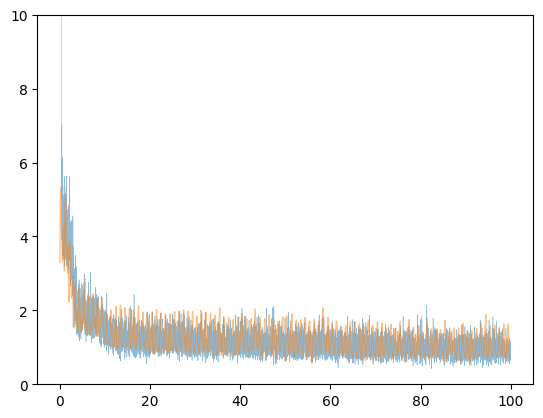

In [43]:


x1 = np.arange(len(tr_loss))/len(trainloader)
x2 = np.arange(len(te_loss))/len(testloader) 
plt.plot(x1, tr_loss, lw=0.4, alpha=0.5)
plt.plot(x2, te_loss, lw=1, alpha=0.5)
plt.ylim(0, 10)

In [44]:
def plot_all_pred(mpnn, dataloader, pred_points):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4))

    for idx in range(len(dataloader.dataset)):
        atoms = dataloader.dataset.X[[idx]]
        iso_params = dataloader.dataset.y[[idx]][:,:-2]
        atoms = atoms.cuda().float()
        iso_params = iso_params.numpy()


        
        x = 10**np.arange(1,7.01,0.01)
        true_p = langmuirfreudlich(iso_params, x)
        ax[1].plot(x, true_p, c='r', lw=.2, alpha=.75)

        with torch.no_grad():
            mpnn.eval()
            p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1))[1][0].cpu()

        ax[0].plot(pred_points, p_hat, c='b', lw=.2, alpha=.75)
        
    ax[0].set_ylim( 0,4)
    ax[0].set_xscale('log')
    ax[1].set_ylim( 0,4)
    ax[1].set_xscale('log')
    ax[0].set_title('Predicted Isotherms')
    ax[1].set_title('True Isotherms')
    ax[0].set_xlim(x[0], x[-1])
    ax[1].set_xlim(x[0], x[-1])
    ax[0].set_ylabel('Pressure (Pa)')
    ax[0].set_xlabel('Loading (mol/kg)')
    ax[1].set_ylabel('Pressure (Pa)')
    ax[1].set_xlabel('Loading (mol/kg)')
    #ax[0].vlines(pred_points, ymin=0, ymax=4, ls='--', lw=.2)
    return fig, ax


def plot_true_pred(mpnn, dataloader, idx, pred_points, fig=None, ax=None, cumsum=False, relu=False):

    atoms = dataloader.dataset.X[[idx]]
    _iso_params = dataloader.dataset.y[[idx]][:,:-2]
    atoms = atoms.cuda().float()
    _iso_params = _iso_params.numpy()
    
    idx = np.where((iso_params == _iso_params).all(1))[0]


    if fig is None:
        fig, ax = plt.subplots()

    x = 10**np.arange(1,7.01,0.01)
    true_p = langmuirfreudlich(_iso_params, x)
    ax.plot(x, true_p, label='fitted isotherm')

    with torch.no_grad():
        mpnn.eval()
        p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1), pred_points=torch.tensor(pred_points).cuda().float())[1][0].cpu()
    #print(p_hat)
    ax.plot(pred_points, p_hat, label='predicted isotherm')
    ax.set_ylim(0,4)
    ax.set_xlim(x[0], x[-1])
    ax.set_xscale('log')
    ax.vlines(pred_points, ymin=0, ymax=4, ls='--', lw=.2)
    ax.set_xlabel('Pressure (Pa)')
    ax.set_ylabel('Loading (mol/kg)')
    
    raw_p = np.array([1e1,1e2,3e2,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6,1e7])
    ax.scatter(raw_p, raw_data[idx], label='raw data')
    plt.legend()
    return fig, ax

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Predicted Isotherms'}, xlabel='Loading (mol/kg)', ylabel='Pressure (Pa)'>,
        <Axes: title={'center': 'True Isotherms'}, xlabel='Loading (mol/kg)', ylabel='Pressure (Pa)'>],
       dtype=object))

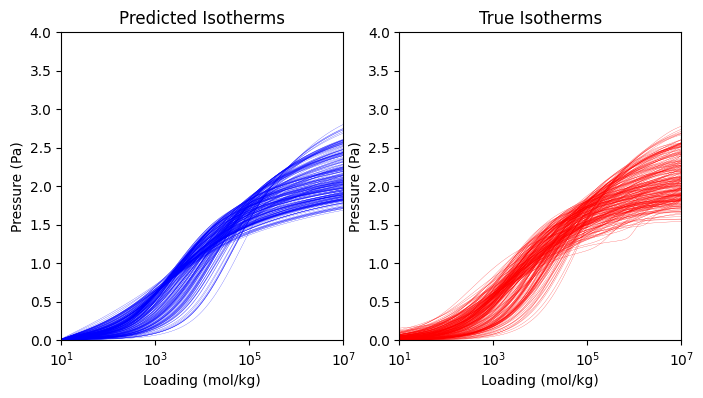

In [45]:
plot_all_pred(mpnn, testloader, pred_points)

In [46]:
# # something went wrong with fitting MFI_33 and MFI_3296
# n = 3296 - 2

# # atoms = np.zeros((n, 96))
# raw_arr = np.zeros((n, 12))


# idxes = np.arange(1,n+1+2)
# idxes = [i for i in idxes if i not in [33,3296]]

# for zeo in tqdm(range(len(idxes))):



#     idx = idxes[zeo]
    
#     raw_arr[zeo] = np.loadtxt(f'Data_isotherms/old/MFI/load/CO2-MFI-{idx}.load', skiprows=1, usecols=1)

In [47]:
# np.save('Data_isotherms/MFI/raw_data.npy', raw_arr)

In [48]:
# np.loadtxt(f'Data_isotherms/old/MFI/load/CO2-MFI-1.load', skiprows=1, usecols=1)

In [49]:
raw_data = np.load('Data_Isotherms/MFI/raw_data.npy')

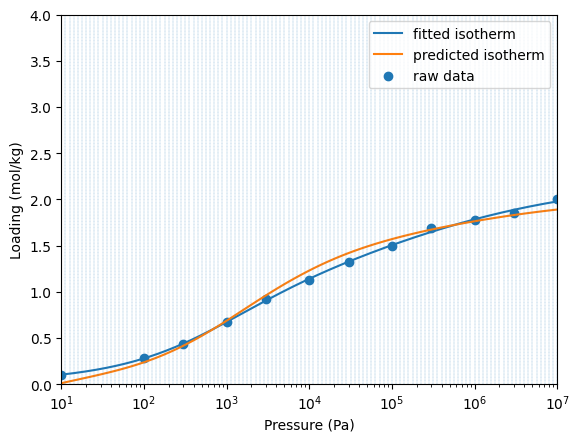

In [50]:
f,a = plot_true_pred(mpnn, testloader, np.random.choice(np.arange(len(testloader.dataset))), pred_points, cumsum=False, relu=False)

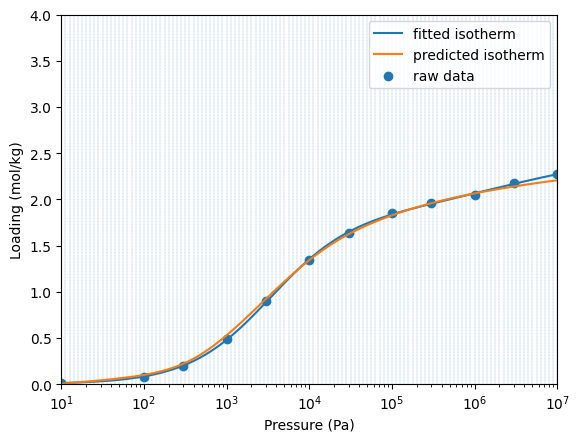

In [51]:
f,a = plot_true_pred(mpnn, testloader, np.random.choice(np.arange(len(testloader.dataset))), pred_points, cumsum=False, relu=False)

In [52]:
pp2 = get_pred_points(5)

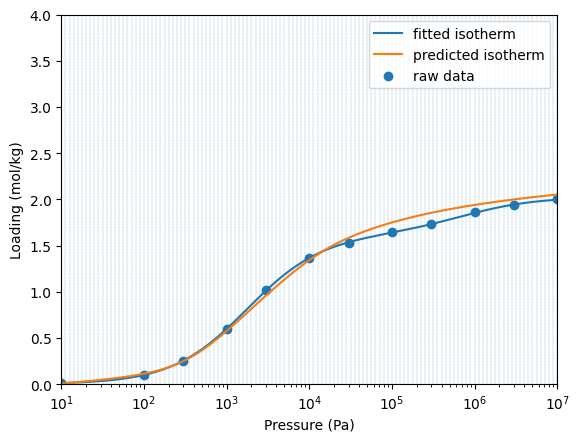

In [53]:
f,a = plot_true_pred(mpnn, testloader, 5, pred_points, cumsum=False, relu=False)

In [54]:
# f,a = plot_true_pred(mpnn, testloader, 5, pp2, cumsum=False, relu=False)

In [55]:
len(testloader.dataset)

246

In [56]:
bad = [368,394,330,136]

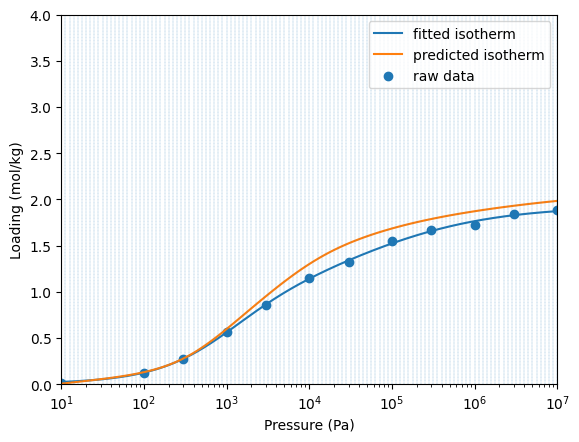

In [57]:
f,a = plot_true_pred(mpnn, testloader, 135, pred_points, cumsum=False, relu=False)

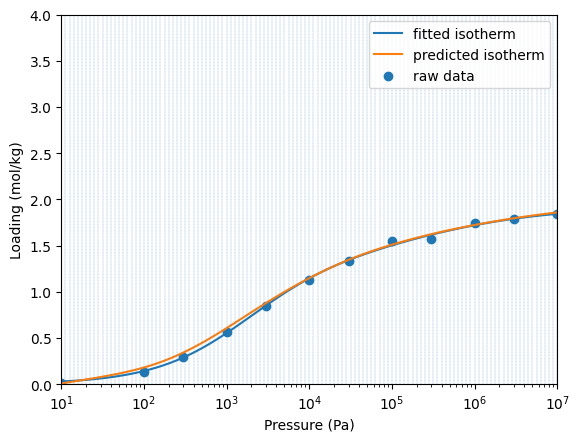

In [58]:
f,a = plot_true_pred(mpnn, testloader, 130, pred_points, cumsum=False, relu=False)

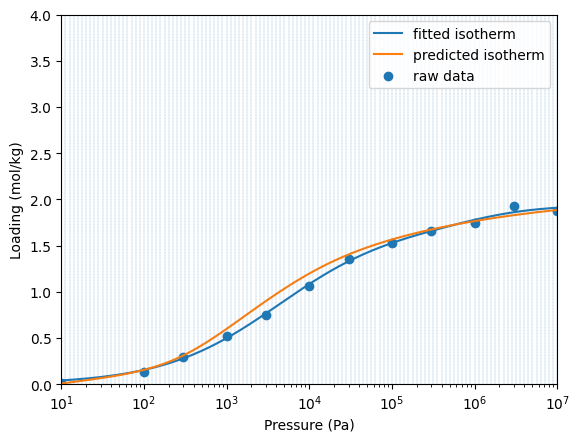

In [59]:
f,a = plot_true_pred(mpnn, testloader, 136, pred_points, cumsum=False, relu=False)

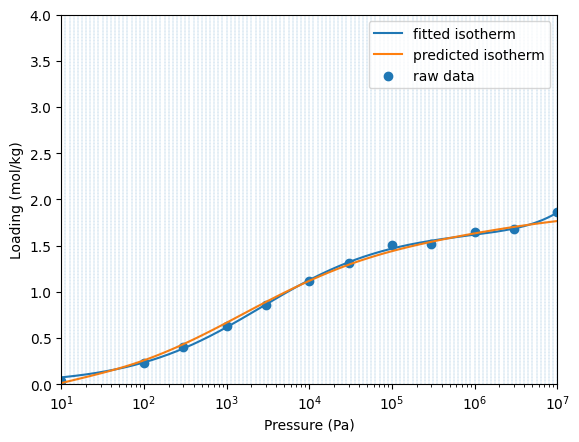

In [60]:
f,a = plot_true_pred(mpnn, testloader, 69, pred_points, cumsum=False, relu=False)

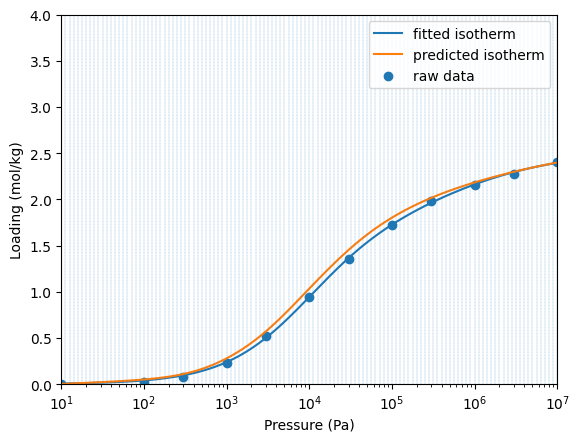

In [61]:
f,a = plot_true_pred(mpnn, testloader, 42, pred_points, cumsum=False, relu=False)

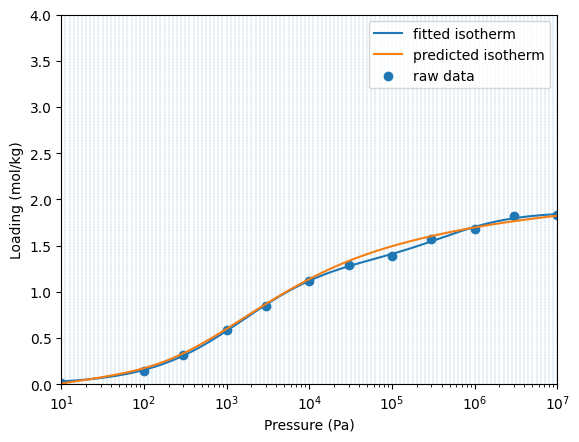

In [62]:
f,a = plot_true_pred(mpnn, testloader, 2, pred_points, cumsum=False, relu=False)

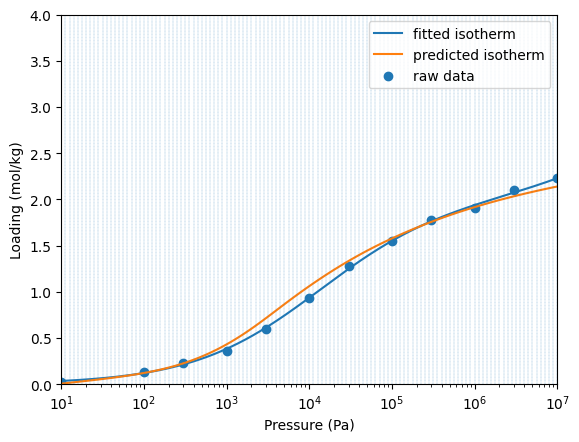

In [63]:
f,a = plot_true_pred(mpnn, testloader, 3, pred_points, cumsum=False, relu=False)

In [64]:
pp,ip,pt,it = mpnn.predict(testloader, torch.tensor(get_pred_points(20)).cuda().float())

(array([  1.,   2.,   5.,  29., 138.,  62.,   5.,   0.,   2.,   2.]),
 array([-15.28281687, -12.16491106,  -9.04700524,  -5.92909943,
         -2.81119361,   0.3067122 ,   3.42461802,   6.54252383,
          9.66042964,  12.77833546,  15.89624127]),
 <BarContainer object of 10 artists>)

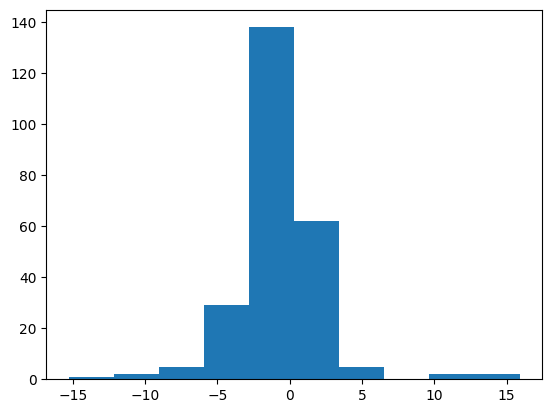

In [65]:
plt.hist((pp-pt)[:,0])

Text(0, 0.5, 'pred')

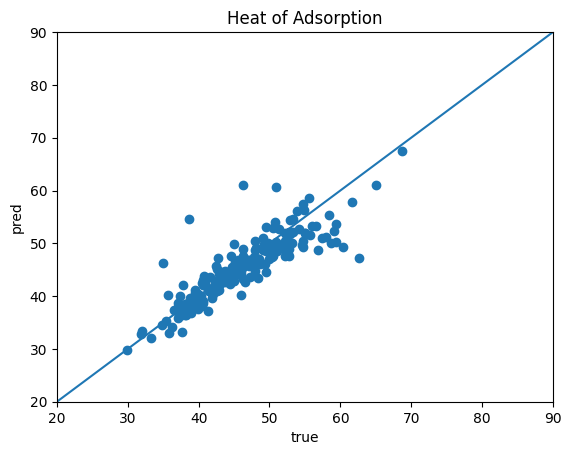

In [66]:
plt.scatter(pt[:,0], pp[:,0])
plt.xlim(20,90)
plt.ylim(20,90)
plt.plot([20,90],[20,90])
plt.title("Heat of Adsorption")
plt.xlabel('true')
plt.ylabel('pred')

In [67]:
np.abs(pt[:,0] - pp[:,0]).mean()

1.9016176167888694

Text(0, 0.5, 'pred')

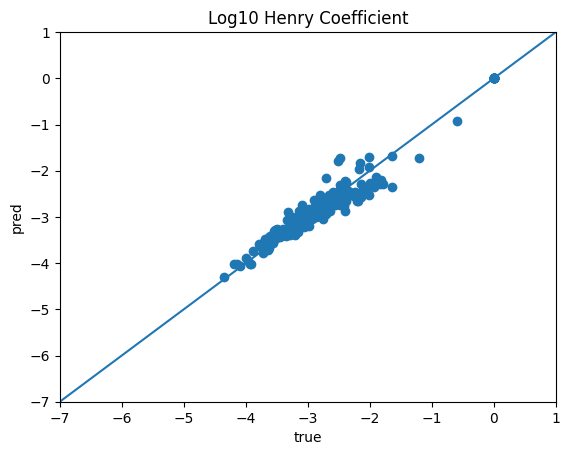

In [68]:
plt.scatter(pt[:,1], pp[:,1])
plt.xlim(-7,1)
plt.ylim(-7,1)
plt.plot([-7,1],[-7,1])
plt.title("Log10 Henry Coefficient")
plt.xlabel('true')
plt.ylabel('pred')

(array([ 1.,  7., 15., 27., 94., 71., 25.,  3.,  1.,  2.]),
 array([-0.72524993, -0.5758492 , -0.42644847, -0.27704774, -0.12764701,
         0.02175372,  0.17115445,  0.32055518,  0.46995591,  0.61935664,
         0.76875737]),
 <BarContainer object of 10 artists>)

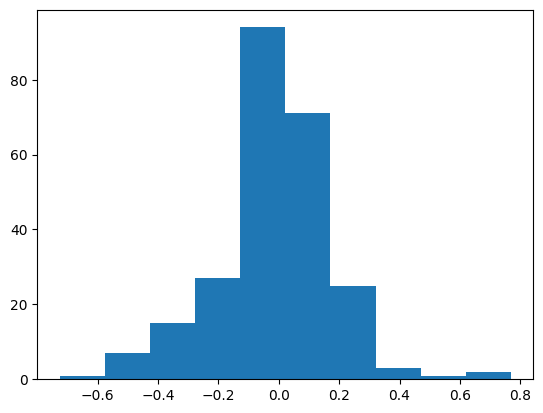

In [69]:
plt.hist((pp-pt)[:,1])

In [70]:
iso_err = np.abs(ip - it)


Text(0, 0.5, 'Pred')

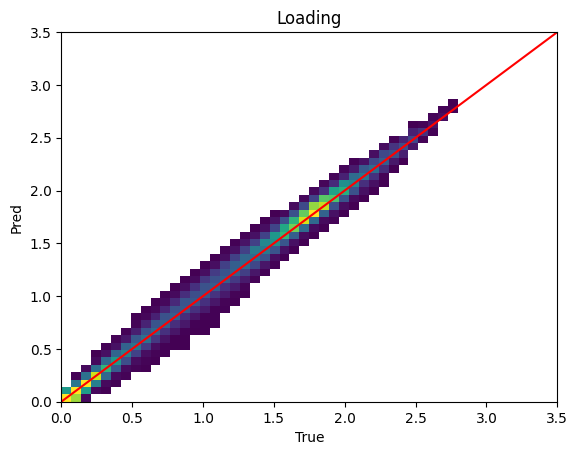

In [71]:
plt.hist2d(it.flatten(), ip.flatten(), bins=50, cmin=1, vmax=500, range=([0,3.5],[0,3.5]))
plt.xlim(0,3.5)
plt.ylim(0,3.5)
plt.plot([0,3.5],[0,3.5], c='red')
plt.title('Loading')
plt.xlabel('True')
plt.ylabel('Pred')

In [72]:
ip.shape, it.shape

((246, 121), (246, 121))

In [73]:
np.mean(iso_err)

0.04212129010238175

(array([27., 33., 66., 53., 28., 19., 12.,  4.,  3.,  1.]),
 array([0.        , 0.01345949, 0.02691898, 0.04037847, 0.05383796,
        0.06729744, 0.08075693, 0.09421642, 0.10767591, 0.1211354 ,
        0.13459489]),
 <BarContainer object of 10 artists>)

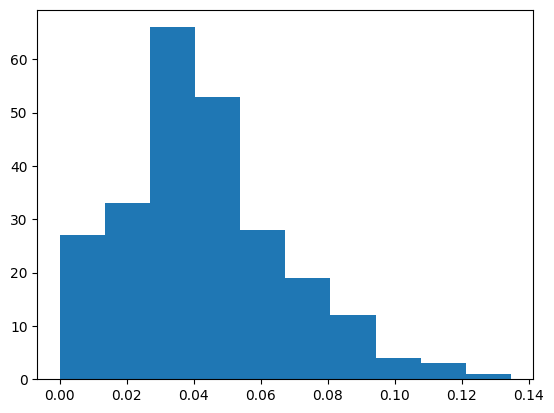

In [74]:
plt.hist(iso_err.mean(1))

In [75]:
iso_err.shape

(246, 121)

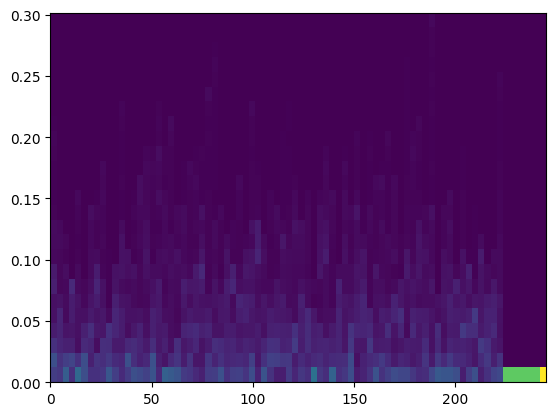

In [76]:
n = iso_err.shape[0]
x = np.repeat(np.arange(n), iso_err.shape[1])
y = iso_err.flatten()

plt.hist2d(x, y, bins=(80,25));

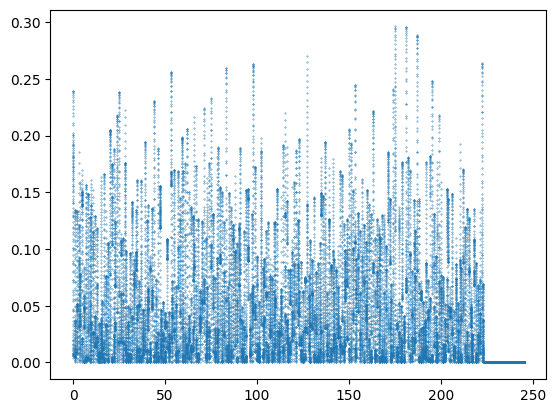

In [139]:
plt.scatter(x,y, s=0.1)

In [140]:
iso_err.mean(0)

array([0.02204643, 0.01976477, 0.01791902, 0.01661275, 0.01589807,
       0.01572452, 0.01585669, 0.01614539, 0.01659105, 0.01710597,
       0.01771124, 0.01839777, 0.01912167, 0.01987605, 0.02064178,
       0.02141741, 0.02221571, 0.023035  , 0.02384654, 0.02466694,
       0.02552092, 0.02639997, 0.02731752, 0.0282508 , 0.02929146,
       0.03043578, 0.03170612, 0.03303714, 0.03442431, 0.03583128,
       0.03727405, 0.03871393, 0.04014115, 0.04154675, 0.04292017,
       0.04424317, 0.04546843, 0.04666002, 0.04791223, 0.04916559,
       0.05048649, 0.05179536, 0.05311411, 0.05448545, 0.05598955,
       0.05757218, 0.05913921, 0.06068342, 0.06228911, 0.06395751,
       0.06552631, 0.06699759, 0.06835526, 0.06963545, 0.07076629,
       0.07189106, 0.07289229, 0.07376548, 0.07445804, 0.07516767,
       0.07587306, 0.07640012, 0.0767362 , 0.07684457, 0.07674363,
       0.07652339, 0.07605245, 0.07546713, 0.07473049, 0.07385055,
       0.07289417, 0.07188299, 0.07078854, 0.06955576, 0.06822

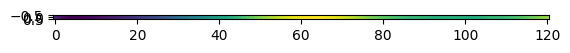

In [141]:
plt.imshow(iso_err.mean(0,keepdims=True))